In [1]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import bambi as bmb
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-darkgrid")
SEED = 42

### 1. Load data

In [3]:
df = pd.read_csv("../../urine_test_data.csv")
df

,Sample_ID,Organism_1,Organism_2,Organism_3,Organism_4,Organism_5,Organism_6,Organism_7,Organism_8,Organism_9,...,Antibiotic_13,Antibiotic_14,Antibiotic_15,Antibiotic_16,Antibiotic_17,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5
0,Sample_0001,675,291,0,204,666,0,0,0,799,...,S,S,R,S,S,0,0,0,0,0
1,Sample_0002,692,377,0,0,0,971,0,0,0,...,R,R,S,S,S,0,1,0,0,0
2,Sample_0003,0,173,0,0,0,25,0,0,0,...,S,R,S,S,S,0,0,0,0,0
3,Sample_0004,811,0,710,0,0,0,0,485,0,...,S,S,R,S,R,0,0,0,0,0
4,Sample_0005,708,553,0,0,0,0,0,0,0,...,S,S,R,S,S,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Sample_0996,57,0,0,670,0,0,0,0,0,...,S,S,R,S,S,0,0,0,0,0
996,Sample_0997,221,0,207,0,0,0,506,0,0,...,S,S,R,S,S,0,0,0,0,0
997,Sample_0998,0,0,0,0,0,0,0,0,0,...,S,S,R,R,S,0,0,0,0,0
998,Sample_0999,0,574,0,0,0,0,0,817,0,...,R,S,R,S,S,0,1,0,0,0


### 2. Preprocess data

In [12]:
scaler = StandardScaler()
organism_columns = ['Organism_'+str(i) for i in range(1,11)]

# standardize data
df_processed = scaler.fit_transform(df[organism_columns])
df_processed = pd.DataFrame(df_processed,columns=organism_columns)
df_processed['Antibiotic_1']=df['Antibiotic_1'].copy()
df_processed['Antibiotic_2']=df['Antibiotic_2'].copy()
df_processed['Antibiotic_3']=df['Antibiotic_3'].copy()

### 3. Fit model

In [5]:
# specify and fit model in Bambi
formula = "Antibiotic_1['R'] ~ Organism_1 + Organism_2 + Organism_3 + Organism_4 + Organism_5 + Organism_6 + Organism_7 + Organism_8 + Organism_9 + Organism_10"
model = bmb.Model(formula, df_processed, family="bernoulli")
model.build()
results = model.fit(
    draws=1000,tune=1000, target_accept=0.85, random_seed=SEED, idata_kwargs={"log_likelihood": True}
)

Modeling the probability that Antibiotic_1==R
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Organism_1, Organism_2, Organism_3, Organism_4, Organism_5, Organism_6, Organism_7, Organism_8, Organism_9, Organism_10]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33 seconds.


### 4. Trace plot

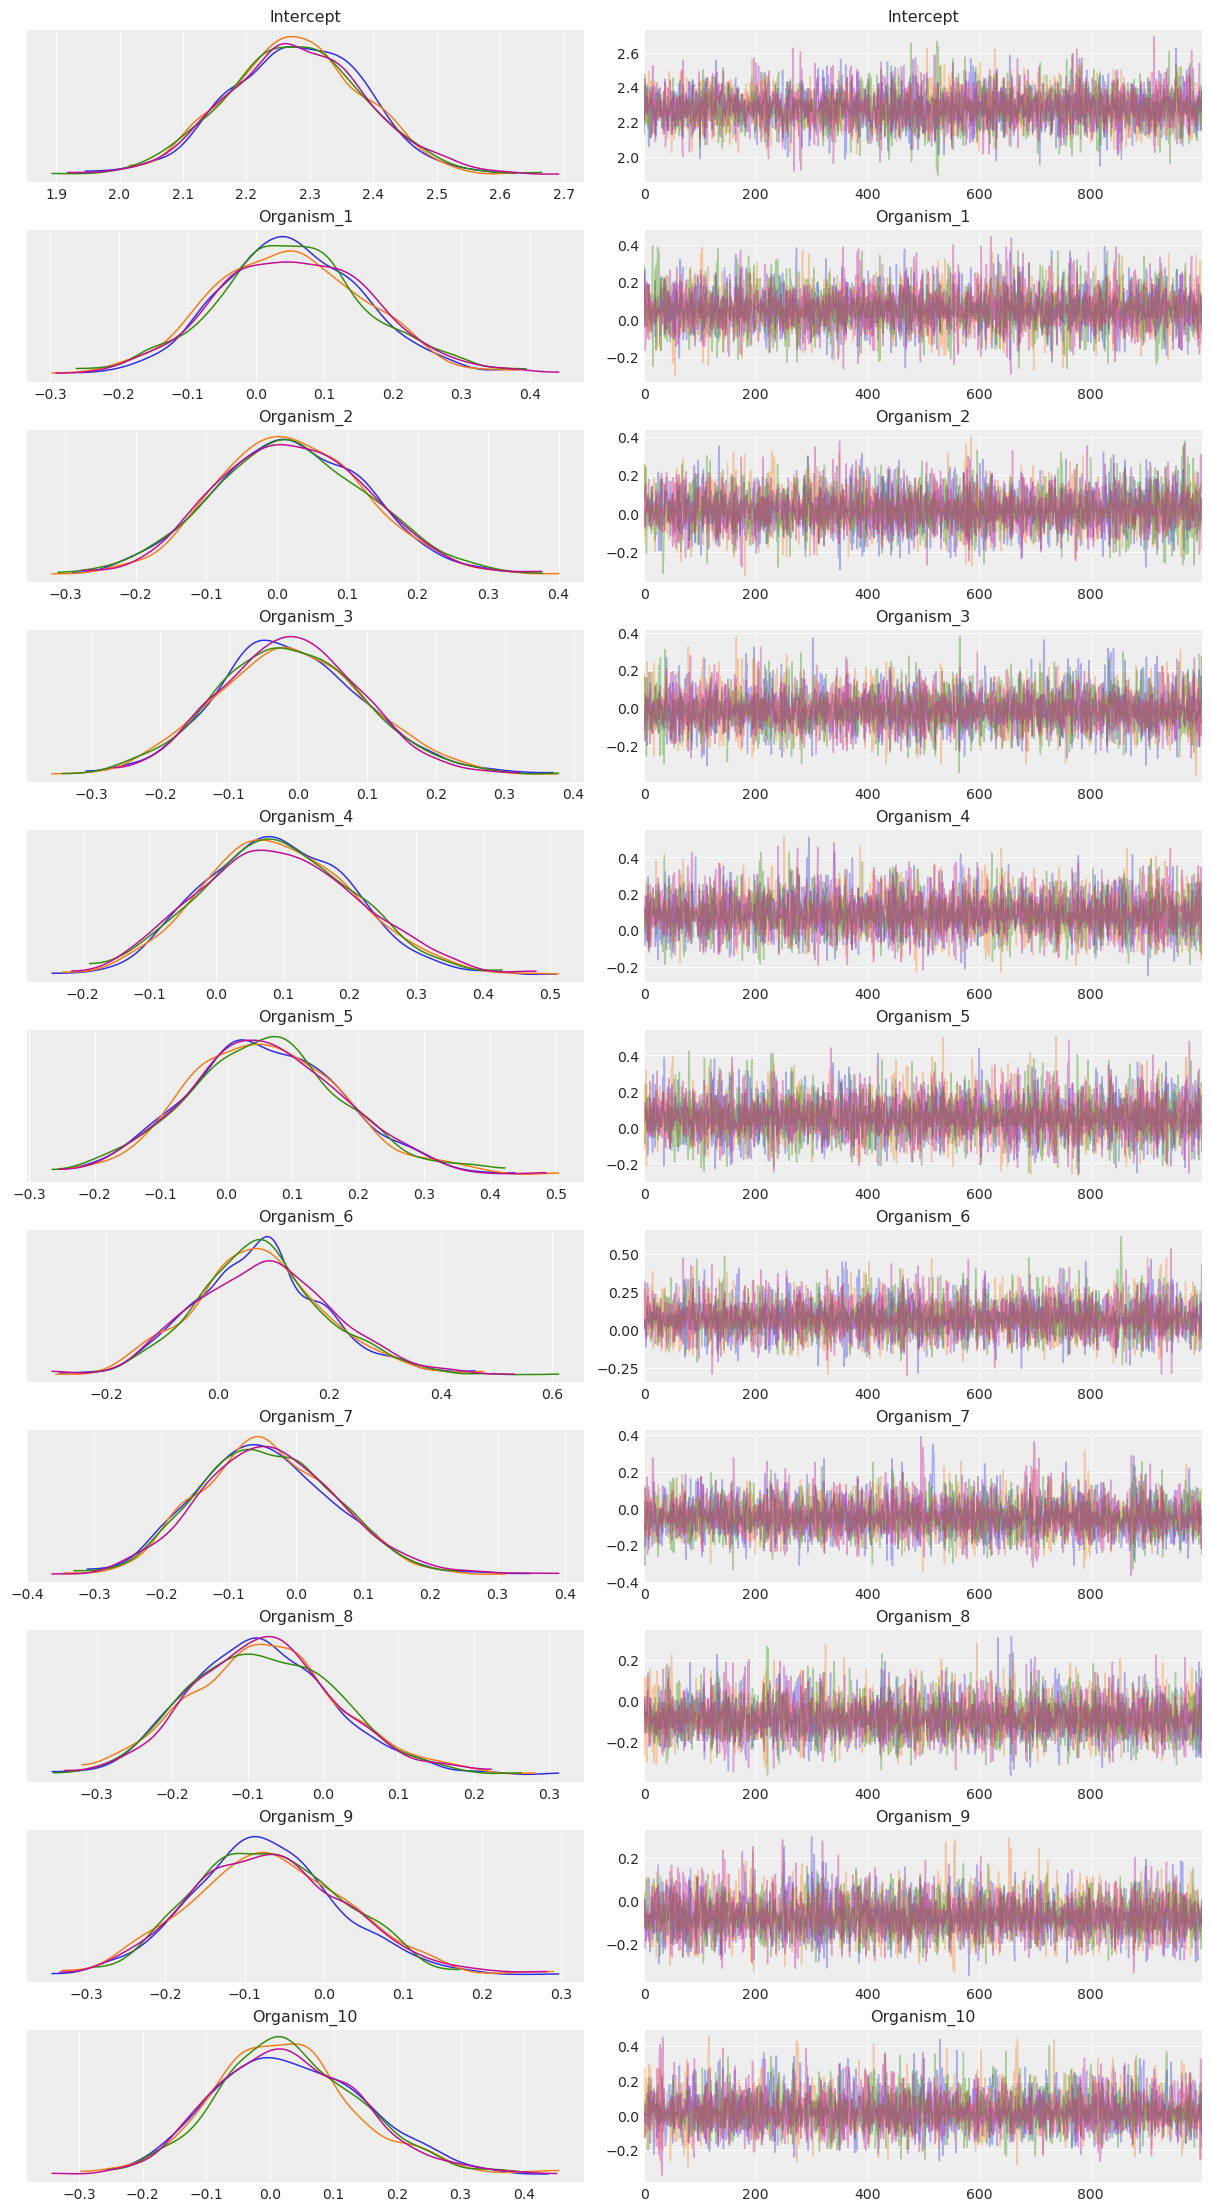

In [6]:
az.plot_trace(results,compact=False)
plt.show()

### 5. Posterior summary statistics

In [7]:
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.279,0.108,2.085,2.489,0.001,0.001,6540.0,3168.0,1.0
Organism_1,0.054,0.112,-0.170,0.253,0.001,0.002,6344.0,2950.0,1.0
Organism_2,0.021,0.107,-0.176,0.224,0.001,0.002,7271.0,3307.0,1.0
Organism_3,-0.010,0.106,-0.210,0.188,0.001,0.002,6562.0,3228.0,1.0
Organism_4,0.093,0.114,-0.127,0.294,0.001,0.001,6501.0,3192.0,1.0
Organism_5,0.059,0.118,-0.156,0.291,0.001,0.002,7032.0,2901.0,1.0
Organism_6,0.078,0.119,-0.152,0.293,0.001,0.002,6815.0,3007.0,1.0
Organism_7,-0.042,0.101,-0.218,0.147,0.001,0.002,6708.0,2582.0,1.0
Organism_8,-0.077,0.098,-0.264,0.104,0.001,0.001,6890.0,2806.0,1.0
Organism_9,-0.069,0.095,-0.249,0.105,0.001,0.001,6487.0,2871.0,1.0


### 6. Predictive check

<Axes: xlabel='Antibiotic_1 / Antibiotic_1'>

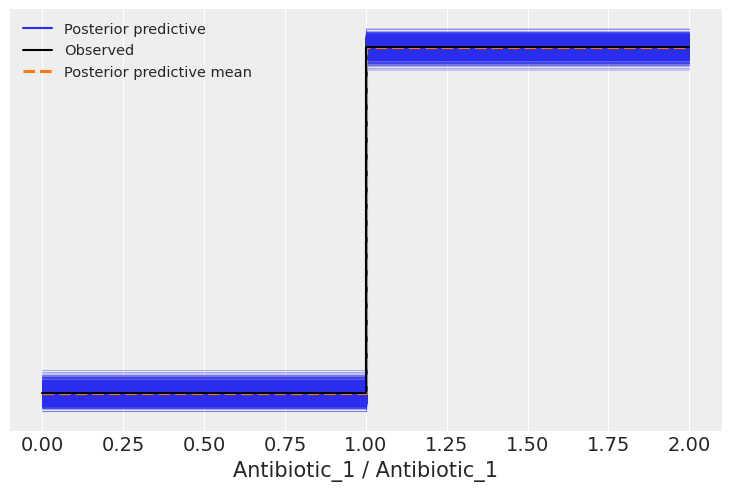

In [8]:
# add posterior predictive sample to results
model.predict(results, kind="pps")

# plot ppc
az.plot_ppc(results)

Model's fit is good.

### Repeat for Antibiotic_2

Modeling the probability that Antibiotic_2==R
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Organism_1, Organism_2, Organism_3, Organism_4, Organism_5, Organism_6, Organism_7, Organism_8, Organism_9, Organism_10]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


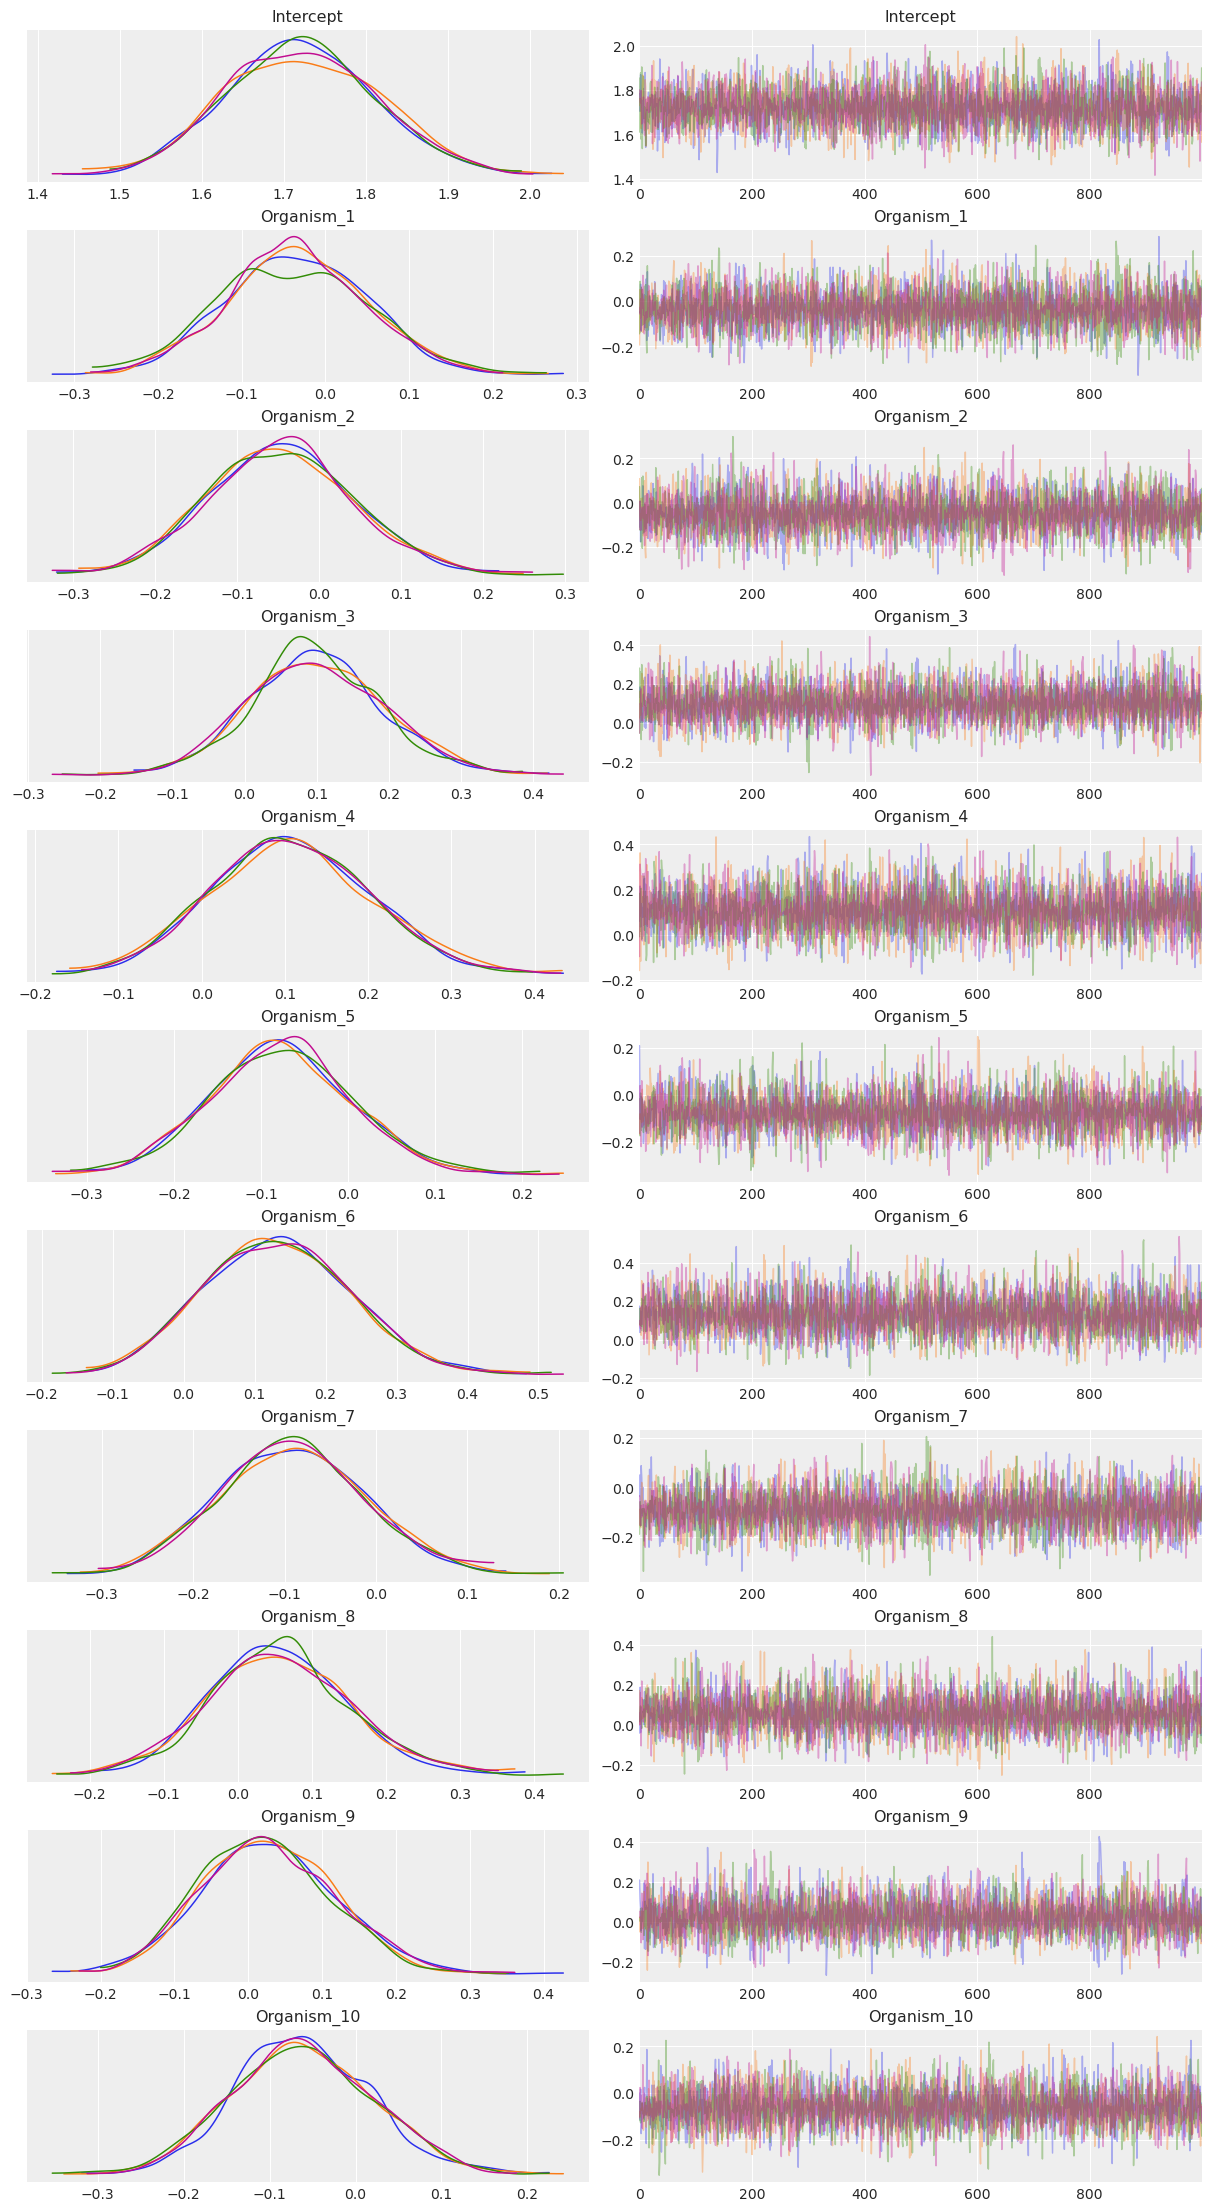

In [13]:
# specify and fit model in Bambi
formula = "Antibiotic_2['R'] ~ Organism_1 + Organism_2 + Organism_3 + Organism_4 + Organism_5 + Organism_6 + Organism_7 + Organism_8 + Organism_9 + Organism_10"
model = bmb.Model(formula, df_processed, family="bernoulli")
model.build()
results = model.fit(
    draws=1000,tune=1000, target_accept=0.85, random_seed=SEED, idata_kwargs={"log_likelihood": True})

# Trace plot
az.plot_trace(results,compact=False)
plt.show()

In [14]:
# posterior summary statistics
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.721,0.091,1.554,1.892,0.001,0.001,6206.0,3356.0,1.00
Organism_1,-0.035,0.086,-0.200,0.122,0.001,0.001,7200.0,3065.0,1.01
Organism_2,-0.046,0.089,-0.211,0.122,0.001,0.001,6411.0,2833.0,1.00
Organism_3,0.100,0.093,-0.086,0.267,0.001,0.001,6804.0,2870.0,1.00
Organism_4,0.108,0.096,-0.062,0.295,0.001,0.001,6568.0,3189.0,1.00
Organism_5,-0.077,0.083,-0.235,0.071,0.001,0.001,6938.0,3206.0,1.00
Organism_6,0.132,0.103,-0.056,0.320,0.001,0.001,7015.0,3229.0,1.00
Organism_7,-0.091,0.080,-0.240,0.059,0.001,0.001,6035.0,2873.0,1.00
Organism_8,0.057,0.095,-0.119,0.246,0.001,0.001,6861.0,2817.0,1.00
Organism_9,0.027,0.092,-0.142,0.196,0.001,0.002,6051.0,2733.0,1.00


<Axes: xlabel='Antibiotic_2 / Antibiotic_2'>

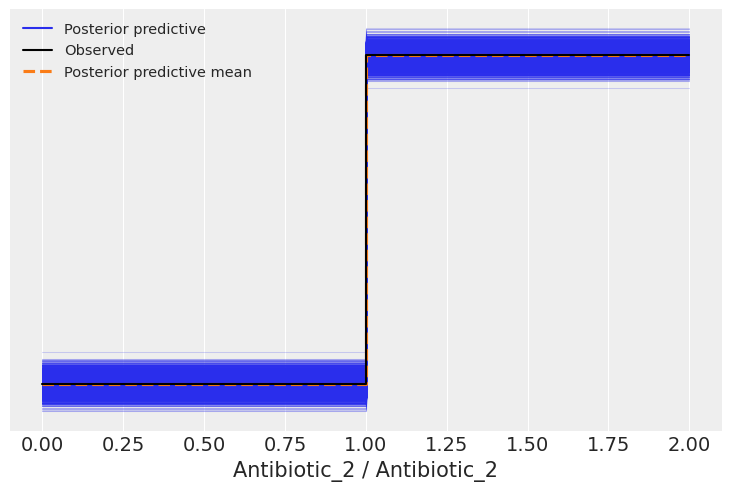

In [15]:
# add posterior predictive sample to results
model.predict(results, kind="pps")

# plot ppc
az.plot_ppc(results)

Model's fit is good.

### Repeat for Antibiotic_3

Modeling the probability that Antibiotic_3==R
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Organism_1, Organism_2, Organism_3, Organism_4, Organism_5, Organism_6, Organism_7, Organism_8, Organism_9, Organism_10]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.


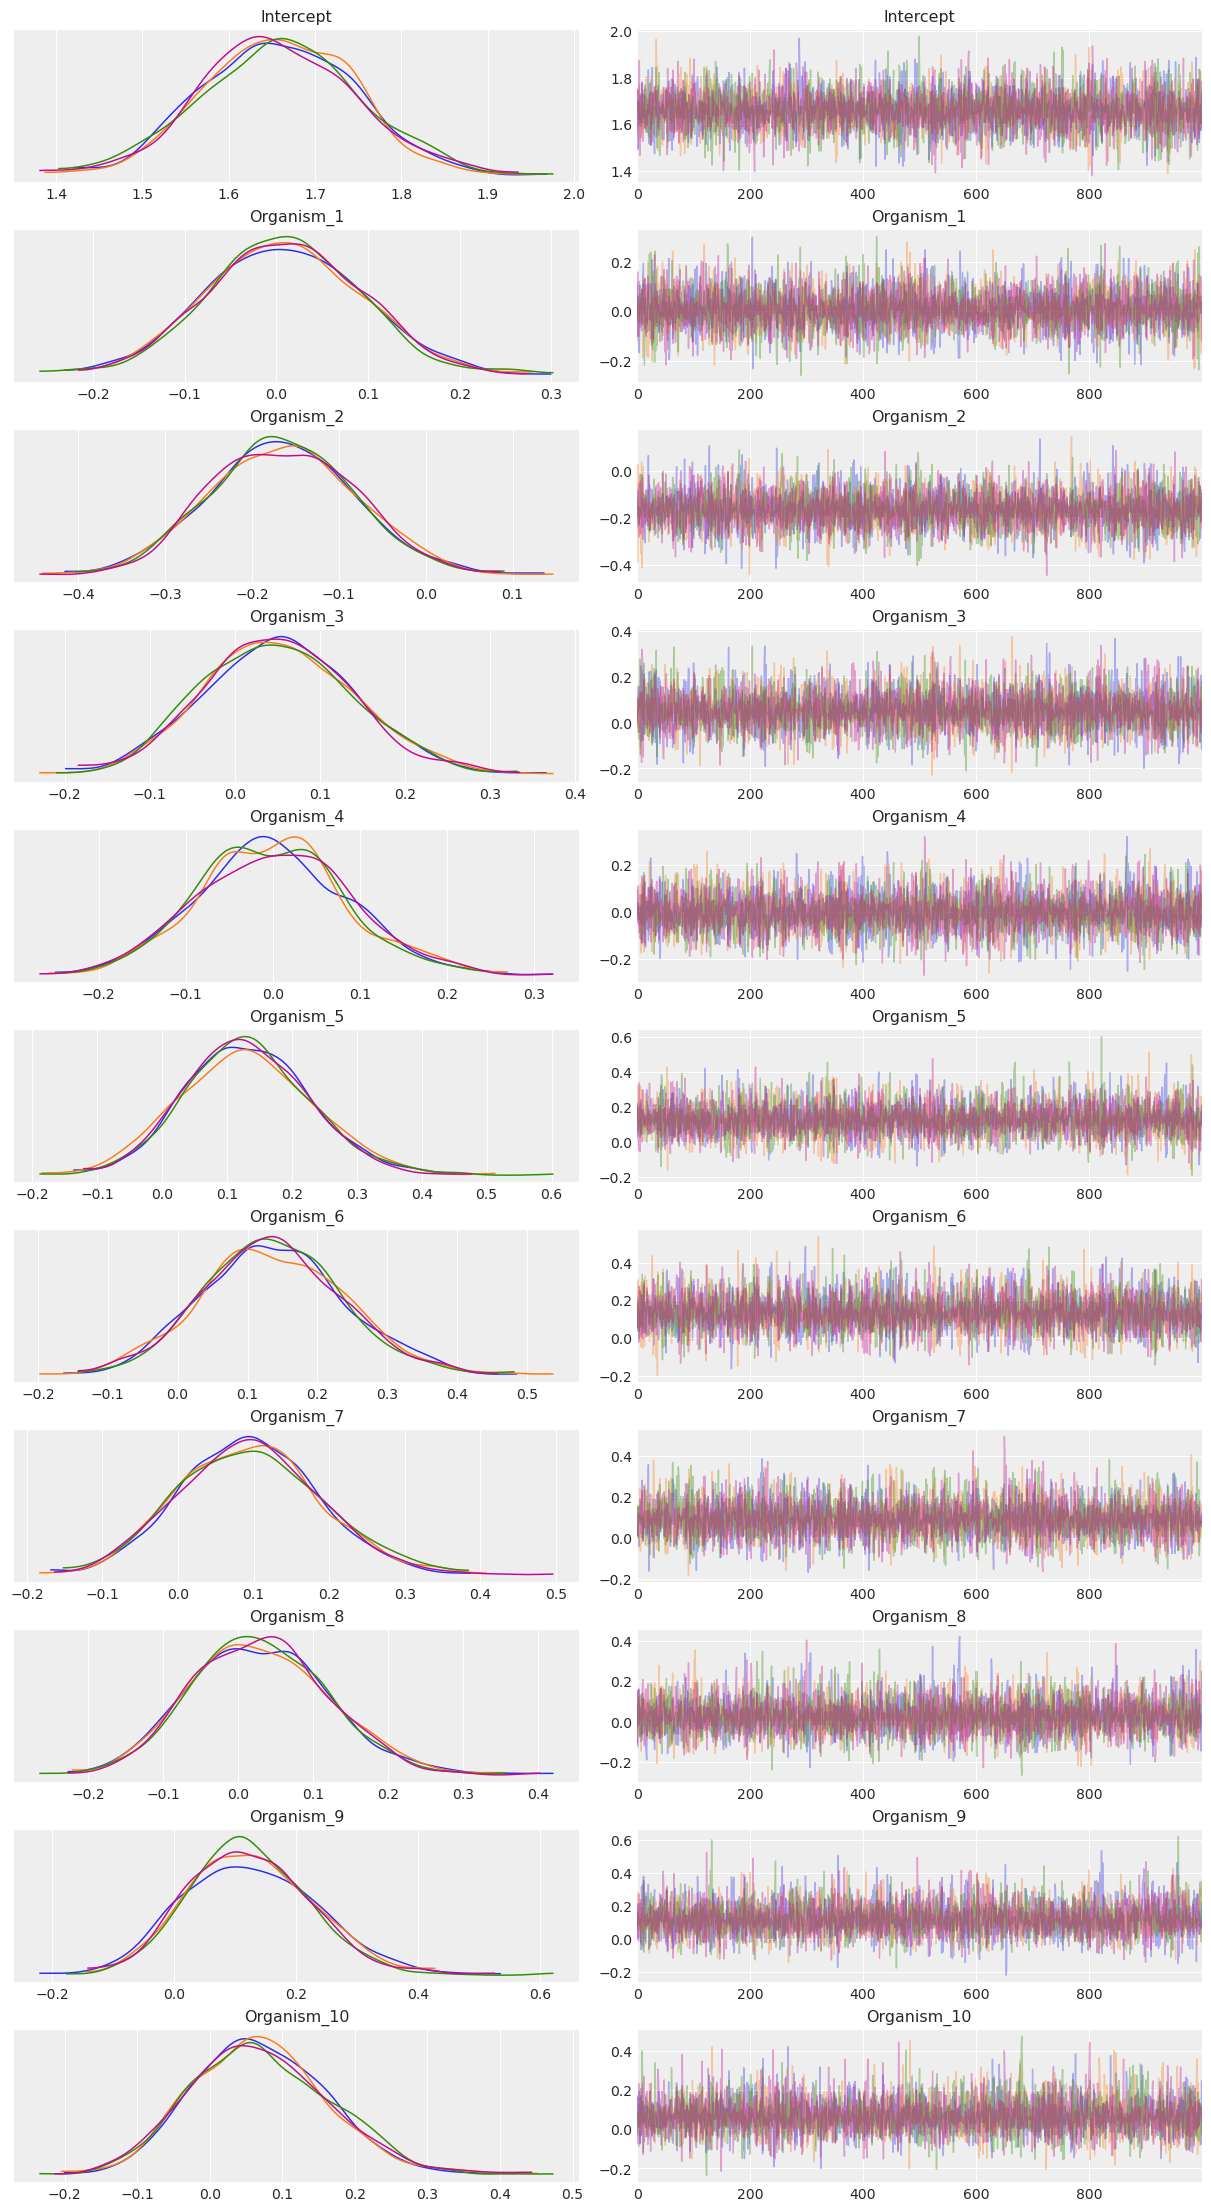

In [16]:
# specify and fit model in Bambi
formula = "Antibiotic_3['R'] ~ Organism_1 + Organism_2 + Organism_3 + Organism_4 + Organism_5 + Organism_6 + Organism_7 + Organism_8 + Organism_9 + Organism_10"
model = bmb.Model(formula, df_processed, family="bernoulli")
model.build()
results = model.fit(
    draws=1000,tune=1000, target_accept=0.85, random_seed=SEED, idata_kwargs={"log_likelihood": True})

# Trace plot
az.plot_trace(results,compact=False)
plt.show()

In [17]:
# posterior summary statistics
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.658,0.088,1.496,1.828,0.001,0.001,7148.0,3061.0,1.0
Organism_1,0.009,0.084,-0.151,0.163,0.001,0.001,7602.0,2922.0,1.0
Organism_2,-0.165,0.083,-0.311,-0.003,0.001,0.001,7685.0,2979.0,1.0
Organism_3,0.052,0.089,-0.118,0.214,0.001,0.001,7751.0,2937.0,1.0
Organism_4,0.000,0.085,-0.163,0.160,0.001,0.002,6854.0,2519.0,1.0
Organism_5,0.131,0.097,-0.059,0.303,0.001,0.001,6468.0,2761.0,1.0
Organism_6,0.137,0.101,-0.059,0.322,0.001,0.001,7077.0,2809.0,1.0
Organism_7,0.095,0.093,-0.078,0.269,0.001,0.001,7023.0,2919.0,1.0
Organism_8,0.029,0.092,-0.134,0.205,0.001,0.002,7685.0,2956.0,1.0
Organism_9,0.124,0.104,-0.068,0.313,0.001,0.001,5789.0,2550.0,1.0


<Axes: xlabel='Antibiotic_3 / Antibiotic_3'>

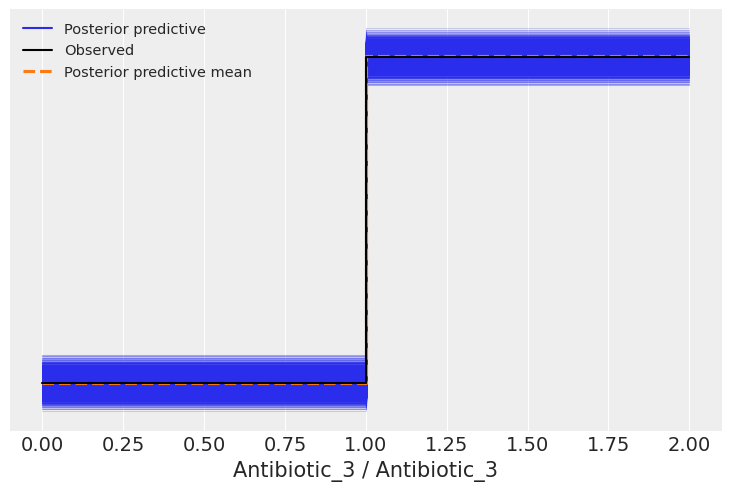

In [18]:
# add posterior predictive sample to results
model.predict(results, kind="pps")

# plot ppc
az.plot_ppc(results)

Model's fit is good.